In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ερώτηση 1.a.

Υλοποιήστε ένα απλό τεχνητό νευρωνικό δίκτυο (fully connected) με δύο κρυφά επίπεδα 256 και
128 νευρώνων αντίστοιχα. Προσαρμόστε το επίπεδο εισόδου (input layer)και το επίπεδο εξόδου
(output layer) κατάλληλα για το dataset που πρέπει να χρησιμοποιήσετε

In [2]:
%cd "/content/drive/MyDrive/ergasia_anagnwrisi_draft"
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset

/content/drive/MyDrive/ergasia_anagnwrisi_draft
fatal: destination path 'Sign-Language-Digits-Dataset' already exists and is not an empty directory.


In [3]:
#dataset management
import os
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from keras.utils import to_categorical
import random
import pandas as pd 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA

#neural model management
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from sklearn.datasets import make_classification

from keras.layers import BatchNormalization

#metrics management
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
import seaborn as sns



In [4]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='/content/drive/MyDrive/ergasia_anagnwrisi_draft/Sign-Language-Digits-Dataset/Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    return X, Y


if __name__ == '__main__':
    x, y = get_dataset()
    print('dataset shape: ',x.shape)
    print('labels shape: ',y.shape)

dataset shape:  (2062, 64, 64, 1)
labels shape:  (2062, 10)


In [5]:
X_train, X_val, Y_train,Y_val = train_test_split(x,y, test_size=0.2, random_state = 42)
X_train, X_test, Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.1, random_state = 42)


x_train= X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
x_val=X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
x_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

print('train dataset shape: ',x_train.shape)
print('validation dataset shape: ',x_val.shape)
print('test dataset shape: ', x_test.shape)

train dataset shape:  (1484, 4096)
validation dataset shape:  (413, 4096)
test dataset shape:  (165, 4096)


In [6]:
#creating object for exercise 1a
model = Sequential()

# 1st hidden layer
model.add(Dense(256,input_shape=(4096,)))
model.add(Dropout(0.2))

# 2nd hidden layer
model.add(Dense(128))
model.add(Dropout(0.2))

#output neuron 
model.add(Dense(10))
#softmax needed in order to get as propability
model.add(Activation('softmax'))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 1,083,018
Trainable params: 1,083,018
Non-trainable params: 0
______________________________________________

# Ερώτηση 1.b. 

Παραγωγή των γραφημάτων train/test – loss ανά εποχή. Εμφανίζεται το πρόβλημα
underfitting/overfitting; Αν ναι, να προτείνετε έναν τρόπο διαχείρισης του φαινομένου. Επίσης να
αιτιολογήσετε ποιος είναι ο βέλτιστος αριθμός εποχών εκπαίδευσης. Για τον βέλτιστο αριθμό
εποχών εκπαίδευσης, ζητείται να εξαχθούν οι μετρικές: accuracy, precision recall, f1 score, confusion
matrix.

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
history = model.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 13ms/step - loss: 12.2354 - accuracy: 0.1192 - f1_m: 0.1133 - precision_m: 0.1233 - recall_m: 0.1058 - val_loss: 3.5651 - val_accuracy: 0.1937 - val_f1_m: 0.1784 - val_precision_m: 0.2026 - val_recall_m: 0.1601

Epoch 00001: val_loss improved from inf to 3.56506, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 3.2011 - accuracy: 0.2675 - f1_m: 0.2514 - precision_m: 0.3078 - recall_m: 0.2142 - val_loss: 2.8631 - val_accuracy: 0.2252 - val_f1_m: 0.2093 - val_precision_m: 0.2529 - val_recall_m: 0.1794

Epoch 00002: val_loss improved from 3.56506 to 2.86311, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 2.9779 - accuracy: 0.3037 - f1_m: 0.2843 - precision_m: 0.3364 - recall_m: 0.2484 - val_loss: 2.2376 - val_accuracy: 0.3414 - val_f1_m: 0.2732 - val_precision_m: 0.4053 - val_recall_m: 0.2080

Epoch 00003: val_loss im

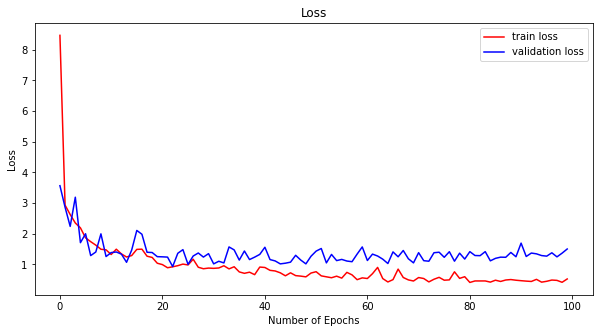

In [9]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'],color='r',label="train loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
best_score = min(history.history['val_loss'])
best_epoch= history.history['val_loss'].index(best_score)
best_val_acc=history.history['val_accuracy'][best_epoch]
best_acc=history.history['accuracy'][best_epoch]
best_precision=history.history['precision_m'][best_epoch]
best_recall=history.history['recall_m'][best_epoch]
best_f1=history.history['f1_m'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)
print('best epoch precision: ',best_precision)
print('best epoch recall: ',best_recall)
print('best epoch f1: ',best_f1)

best epoch:  22
best epoch validation accuracy:  0.7215496301651001
best epoch train accuracy:  0.7156334519386292
best epoch precision:  0.7575751543045044
best epoch recall:  0.6819592118263245
best epoch f1:  0.7173908352851868


In [11]:
#evaluate the network 
score = model.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.0660 - accuracy: 0.6909 - f1_m: 0.7434 - precision_m: 0.7584 - recall_m: 0.7292
Test score:  2.0659756660461426
Test accuracy:  0.6909090876579285


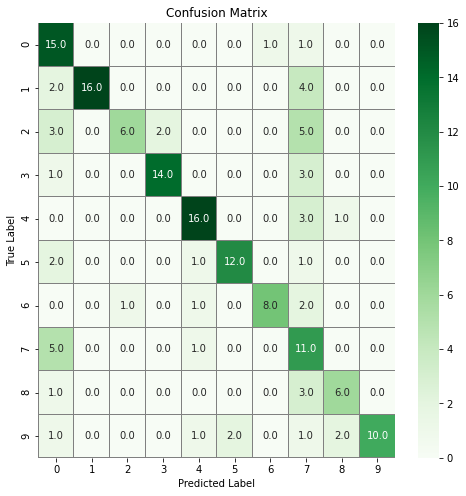

In [12]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Eρώτηση 1.c.

Δοκιμάστε να κανονικοποιήσετε τις εικόνες στο διάστημα [-1,1]. Ταυτόχρονα, προσθέστε την
συνάρτηση ενεργοποίησης (activation function) ReLU (Rectified Linear Unit) ως έξοδο κάθε νευρώνα
στα κρυφά επίπεδα (hidden layer). Υπάρχει αλλαγή στην ακρίβεια (accuracy); Ο αριθμός των εποχών
πριν συμβεί το overfit έχει μεταβληθεί; Γιατί; Ποια είναι η μεταβολή στον αριθμό των παραμέτρων
του δικτύου; 

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(1484, 4096)
(413, 4096)
(165, 4096)


In [14]:
#creating object for exercise 1c
model1c = Sequential()

# 1st hidden layer
model1c.add(Dense(256,input_shape=(4096,)))
model1c.add(Activation('relu'))
model1c.add(Dropout(0.2))

# 2nd hidden layer
model1c.add(Dense(128))
model1c.add(Activation('relu'))
model1c.add(Dropout(0.2))

#output neuron 
model1c.add(Dense(10))
#softmax needed in order to get as propability
model1c.add(Activation('softmax'))
 
model1c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               1048832   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [15]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1c.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1c=model1c.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 6ms/step - loss: 2.3873 - accuracy: 0.1992 - val_loss: 1.3905 - val_accuracy: 0.5472

Epoch 00001: val_loss improved from inf to 1.39046, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 1.3594 - accuracy: 0.5247 - val_loss: 1.1030 - val_accuracy: 0.6489

Epoch 00002: val_loss improved from 1.39046 to 1.10304, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 1.0311 - accuracy: 0.6357 - val_loss: 0.9628 - val_accuracy: 0.6852

Epoch 00003: val_loss improved from 1.10304 to 0.96280, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.8203 - accuracy: 0.7233 - val_loss: 0.9455 - val_accuracy: 0.6828

Epoch 00004: val_loss improved from 0.96280 to 0.94549, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.7

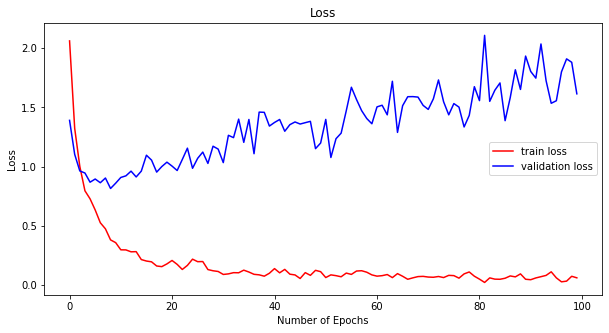

In [16]:
plt.figure(figsize = (10,5))
plt.plot(history1c.history['loss'],color='r',label="train loss")
plt.plot(history1c.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
best_score = min(history1c.history['val_loss'])
best_epoch = history1c.history['val_loss'].index(best_score)
best_val_acc = history1c.history['val_accuracy'][best_epoch]
best_acc = history1c.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  8
best epoch validation accuracy:  0.7506053447723389
best epoch train accuracy:  0.8665767908096313


In [18]:
#evaluate the network 
score = model1c.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 2ms/step - loss: 3.7801 - accuracy: 0.6970
Test score:  3.7800889015197754
Test accuracy:  0.6969696879386902


# Eρώτηση 1.d.

Δοκιμάστε παράλληλα με τις προσθήκες του προηγούμενου ερωτήματος να εφαρμόσετε και batch
normalization σε κάθε επίπεδο. Ποια είναι η μεταβολή στο μέγεθος του δικτύου; Αναμένεται να
υπάρχει και μεταβολή του χρόνου επεξεργασίας του δικτύου; Τι επιτυγχάνει ο αλγόριθμος batch
normalization;

In [19]:
#creating object for exercise 1d
model1d = Sequential()

# 1st hidden layer
model1d.add(Dense(256,input_shape=(4096,)))
model1d.add(BatchNormalization())
model1d.add(Activation('relu'))
model1d.add(Dropout(0.2))

# 2nd hidden layer
model1d.add(Dense(128))
model1d.add(BatchNormalization())
model1d.add(Activation('relu'))
model1d.add(Dropout(0.2))

#output neuron 
model1d.add(Dense(10))
#softmax needed in order to get as propability
model1d.add(Activation('softmax'))
 
model1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               1048832   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)              

In [20]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1d=model1d.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 7ms/step - loss: 2.0182 - accuracy: 0.3254 - val_loss: 1.9483 - val_accuracy: 0.4649

Epoch 00001: val_loss improved from inf to 1.94829, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.8736 - accuracy: 0.7329 - val_loss: 1.1875 - val_accuracy: 0.6174

Epoch 00002: val_loss improved from 1.94829 to 1.18749, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 0.8199 - val_loss: 1.4434 - val_accuracy: 0.5763

Epoch 00003: val_loss did not improve from 1.18749
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.4542 - accuracy: 0.8808 - val_loss: 0.9653 - val_accuracy: 0.6804

Epoch 00004: val_loss improved from 1.18749 to 0.96530, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.3493 - accuracy: 0.9103 - val_loss: 0.89

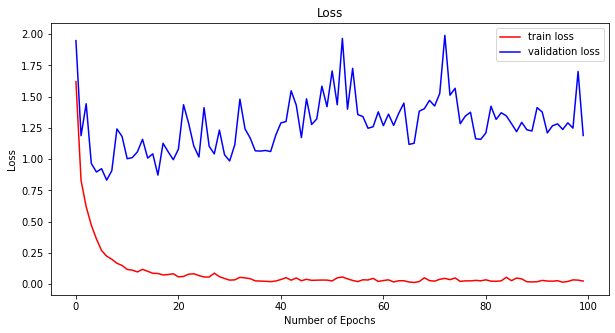

In [21]:
plt.figure(figsize = (10,5))
plt.plot(history1d.history['loss'],color='r',label="train loss")
plt.plot(history1d.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
best_score = min(history1d.history['val_loss'])
best_epoch = history1d.history['val_loss'].index(best_score)
best_val_acc = history1d.history['val_accuracy'][best_epoch]
best_acc = history1d.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  6
best epoch validation accuracy:  0.7336561679840088
best epoch train accuracy:  0.9514824748039246


In [23]:
#evaluate the network 
score = model1d.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.2380 - accuracy: 0.6606
Test score:  2.2380011081695557
Test accuracy:  0.6606060862541199


# Eρώτηση 1.e.

 Υλοποιήστε διάφορες δομές τεχνητών νευρωνικών δικτύων και εντοπίστε αυτό που επιλύει το
πρόβλημα της ταξινόμησης με μεγαλύτερη ακρίβεια. ΣΗΜΕΙΩΣΗ: Μπορείτε για παράδειγμα να
πειραματιστείτε με τον αριθμό των επιπέδων, των νευρώνων ανά επίπεδο, τις συναρτήσεις
ενεργοποίησης, τον αλγόριθμο βελτιστοποίησης (optimization algorithm), την προ-επεξεργασία των
εικόνων του dataset, μείωση διαστάσεων (dimensionality reduction). Eίστε ελεύθερες/ελεύθεροι να
υλοποιήσετε ότι θεωρείτε ότι θα βοηθήσει στην αύξηση της ακρίβειας

## (1e1): 3 hidden layers (256,128,64) 

In [24]:
#creating object for exercise 1d
model1e1 = Sequential()

# 1st hidden layer
model1e1.add(Dense(256,input_shape=(4096,)))
model1e1.add(BatchNormalization())
model1e1.add(Activation('relu'))
model1e1.add(Dropout(0.2))

# 2nd hidden layer
model1e1.add(Dense(128))
model1e1.add(BatchNormalization())
model1e1.add(Activation('relu'))
model1e1.add(Dropout(0.2))

# 3rd hidden layer
model1e1.add(Dense(64))
model1e1.add(BatchNormalization())
model1e1.add(Activation('relu'))
model1e1.add(Dropout(0.2))

#output neuron 
model1e1.add(Dense(10))
#softmax needed in order to get as propability
model1e1.add(Activation('softmax'))
 
model1e1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               1048832   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)              

In [25]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e1=model1e1.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 8ms/step - loss: 2.1979 - accuracy: 0.2685 - val_loss: 1.8708 - val_accuracy: 0.4068

Epoch 00001: val_loss improved from inf to 1.87078, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 1.3070 - accuracy: 0.5663 - val_loss: 1.3141 - val_accuracy: 0.5593

Epoch 00002: val_loss improved from 1.87078 to 1.31407, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.9781 - accuracy: 0.7056 - val_loss: 1.3019 - val_accuracy: 0.5472

Epoch 00003: val_loss improved from 1.31407 to 1.30193, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.7520 - accuracy: 0.7694 - val_loss: 1.0070 - val_accuracy: 0.6659

Epoch 00004: val_loss improved from 1.30193 to 1.00695, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6

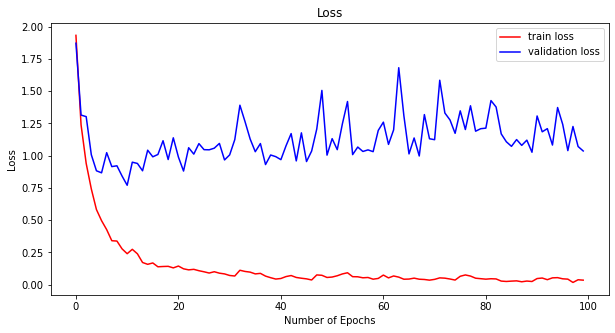

In [26]:
plt.figure(figsize = (10,5))
plt.plot(history1e1.history['loss'],color='r',label="train loss")
plt.plot(history1e1.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
best_score = min(history1e1.history['val_loss'])
best_epoch = history1e1.history['val_loss'].index(best_score)
best_val_acc = history1e1.history['val_accuracy'][best_epoch]
best_acc = history1e1.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  10
best epoch validation accuracy:  0.7699757814407349
best epoch train accuracy:  0.9366576671600342


In [28]:
#evaluate the network 
score = model1e1.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 2ms/step - loss: 1.8619 - accuracy: 0.7273
Test score:  1.8619056940078735
Test accuracy:  0.7272727489471436


## (1e2): 4 hidden layers (256,128,64,32) 

In [29]:
#creating object for exercise 1d
model1e2 = Sequential()

# 1st hidden layer
model1e2.add(Dense(256,input_shape=(4096,)))
model1e2.add(BatchNormalization())
model1e2.add(Activation('relu'))
model1e2.add(Dropout(0.2))

# 2nd hidden layer
model1e2.add(Dense(128))
model1e2.add(BatchNormalization())
model1e2.add(Activation('relu'))
model1e2.add(Dropout(0.2))

# 3rd hidden layer
model1e2.add(Dense(64))
model1e2.add(BatchNormalization())
model1e2.add(Activation('relu'))
model1e2.add(Dropout(0.2))

# 4rd hidden layer
model1e2.add(Dense(32))
model1e2.add(BatchNormalization())
model1e2.add(Activation('relu'))
model1e2.add(Dropout(0.2))

#output neuron 
model1e2.add(Dense(10))
#softmax needed in order to get as propability
model1e2.add(Activation('softmax'))
 
model1e2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
activation_12 (Activation)   (None, 128)              

In [30]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e2=model1e2.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.4456 - accuracy: 0.1544 - val_loss: 2.0228 - val_accuracy: 0.3075

Epoch 00001: val_loss improved from inf to 2.02275, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 1.7973 - accuracy: 0.3735 - val_loss: 1.5034 - val_accuracy: 0.4915

Epoch 00002: val_loss improved from 2.02275 to 1.50344, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4253 - accuracy: 0.5448 - val_loss: 1.3681 - val_accuracy: 0.5061

Epoch 00003: val_loss improved from 1.50344 to 1.36808, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 1.2204 - accuracy: 0.6228 - val_loss: 1.1741 - val_accuracy: 0.6416

Epoch 00004: val_loss improved from 1.36808 to 1.17414, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 1.0

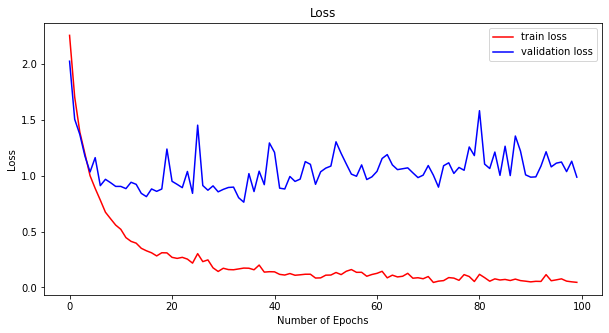

In [31]:
plt.figure(figsize = (10,5))
plt.plot(history1e2.history['loss'],color='r',label="train loss")
plt.plot(history1e2.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
best_score = min(history1e2.history['val_loss'])
best_epoch = history1e2.history['val_loss'].index(best_score)
best_val_acc = history1e2.history['val_accuracy'][best_epoch]
best_acc = history1e2.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  34
best epoch validation accuracy:  0.8014527559280396
best epoch train accuracy:  0.9555255770683289


In [33]:
#evaluate the network 
score = model1e2.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 1.6844 - accuracy: 0.7091
Test score:  1.6844278573989868
Test accuracy:  0.7090908885002136


## (1e3): 4 hidden layers (128,128,64,64) 

In [34]:
#creating object for exercise 1d
model1e3 = Sequential()

# 1st hidden layer
model1e3.add(Dense(128,input_shape=(4096,)))
model1e3.add(BatchNormalization())
model1e3.add(Activation('relu'))
model1e3.add(Dropout(0.2))

# 2nd hidden layer
model1e3.add(Dense(128))
model1e3.add(BatchNormalization())
model1e3.add(Activation('relu'))
model1e3.add(Dropout(0.2))

# 3rd hidden layer
model1e3.add(Dense(64))
model1e3.add(BatchNormalization())
model1e3.add(Activation('relu'))
model1e3.add(Dropout(0.2))

# 4th hidden layer
model1e3.add(Dense(64))
model1e3.add(BatchNormalization())
model1e3.add(Activation('relu'))
model1e3.add(Dropout(0.2))

#output neuron 
model1e3.add(Dense(10))
#softmax needed in order to get as propability
model1e3.add(Activation('softmax'))
 
model1e3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               524416    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
activation_17 (Activation)   (None, 128)              

In [35]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e3=model1e3.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.4953 - accuracy: 0.1297 - val_loss: 2.1193 - val_accuracy: 0.2567

Epoch 00001: val_loss improved from inf to 2.11929, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.8608 - accuracy: 0.3555 - val_loss: 1.6048 - val_accuracy: 0.4867

Epoch 00002: val_loss improved from 2.11929 to 1.60482, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4374 - accuracy: 0.5171 - val_loss: 1.3782 - val_accuracy: 0.5351

Epoch 00003: val_loss improved from 1.60482 to 1.37825, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 1.1680 - accuracy: 0.6288 - val_loss: 1.1728 - val_accuracy: 0.5884

Epoch 00004: val_loss improved from 1.37825 to 1.17284, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.9

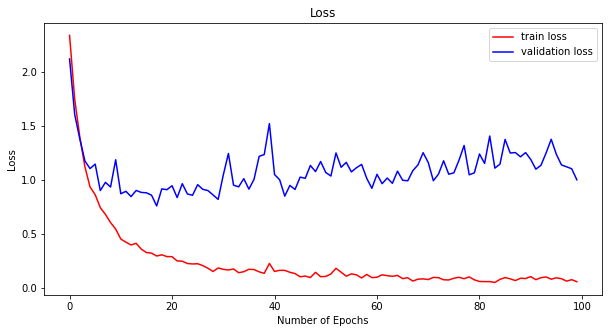

In [36]:
plt.figure(figsize = (10,5))
plt.plot(history1e3.history['loss'],color='r',label="train loss")
plt.plot(history1e3.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
best_score = min(history1e3.history['val_loss'])
best_epoch = history1e3.history['val_loss'].index(best_score)
best_val_acc = history1e3.history['val_accuracy'][best_epoch]
best_acc = history1e3.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  17
best epoch validation accuracy:  0.7845036387443542
best epoch train accuracy:  0.9130727648735046


In [38]:
#evaluate the network 
score = model1e3.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.3569 - accuracy: 0.6667
Test score:  2.356870174407959
Test accuracy:  0.6666666865348816


## (1e4): 5 hidden layers (256,128,128,64,32) 


In [39]:
#creating object for exercise 1d
model1e4 = Sequential()

# 1st hidden layer
model1e4.add(Dense(256,input_shape=(4096,)))
model1e4.add(BatchNormalization())
model1e4.add(Activation('relu'))
model1e4.add(Dropout(0.2))

# 2nd hidden layer
model1e4.add(Dense(128))
model1e4.add(BatchNormalization())
model1e4.add(Activation('relu'))
model1e4.add(Dropout(0.2))

# 3rd hidden layer
model1e4.add(Dense(128))
model1e4.add(BatchNormalization())
model1e4.add(Activation('relu'))
model1e4.add(Dropout(0.2))

# 4th hidden layer
model1e4.add(Dense(64))
model1e4.add(BatchNormalization())
model1e4.add(Activation('relu'))
model1e4.add(Dropout(0.2))

# 5th hidden layer
model1e4.add(Dense(32))
model1e4.add(BatchNormalization())
model1e4.add(Activation('relu'))
model1e4.add(Dropout(0.2))

#output neuron 
model1e4.add(Dense(10))
#softmax needed in order to get as propability
model1e4.add(Activation('softmax'))
 
model1e4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
activation_22 (Activation)   (None, 128)              

In [40]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e4=model1e4.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 10ms/step - loss: 2.4876 - accuracy: 0.1318 - val_loss: 2.5966 - val_accuracy: 0.1429

Epoch 00001: val_loss improved from inf to 2.59660, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 2.0283 - accuracy: 0.2768 - val_loss: 1.9257 - val_accuracy: 0.3051

Epoch 00002: val_loss improved from 2.59660 to 1.92570, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.7439 - accuracy: 0.3945 - val_loss: 1.5756 - val_accuracy: 0.4383

Epoch 00003: val_loss improved from 1.92570 to 1.57564, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4516 - accuracy: 0.5286 - val_loss: 1.3345 - val_accuracy: 0.5278

Epoch 00004: val_loss improved from 1.57564 to 1.33455, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 1.

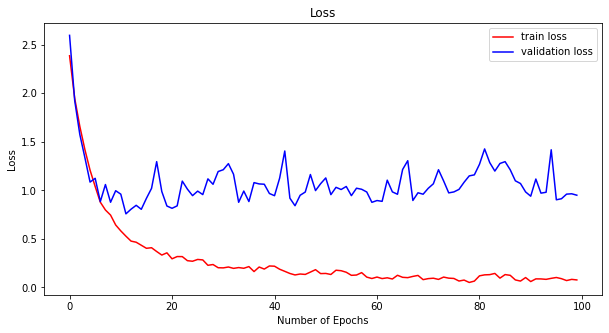

In [41]:
plt.figure(figsize = (10,5))
plt.plot(history1e4.history['loss'],color='r',label="train loss")
plt.plot(history1e4.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
best_score = min(history1e4.history['val_loss'])
best_epoch = history1e4.history['val_loss'].index(best_score)
best_val_acc = history1e4.history['val_accuracy'][best_epoch]
best_acc = history1e4.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  11
best epoch validation accuracy:  0.7384988069534302
best epoch train accuracy:  0.8497304320335388


In [43]:
#evaluate the network 
score = model1e4.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.3152 - accuracy: 0.6606
Test score:  2.315186023712158
Test accuracy:  0.6606060862541199


## (1e5): (1e2) + activation : selu  




In [44]:
#creating object for exercise 1d
model1e5 = Sequential()

# 1st hidden layer
model1e5.add(Dense(256,input_shape=(4096,)))
model1e5.add(BatchNormalization())
model1e5.add(Activation('selu'))
model1e5.add(Dropout(0.2))

# 2nd hidden layer
model1e5.add(Dense(128))
model1e5.add(BatchNormalization())
model1e5.add(Activation('selu'))
model1e5.add(Dropout(0.2))

# 3rd hidden layer
model1e5.add(Dense(64))
model1e5.add(BatchNormalization())
model1e5.add(Activation('selu'))
model1e5.add(Dropout(0.2))

# 4rd hidden layer
model1e5.add(Dense(32))
model1e5.add(BatchNormalization())
model1e5.add(Activation('selu'))
model1e5.add(Dropout(0.2))

#output neuron 
model1e5.add(Dense(10))
#softmax needed in order to get as propability
model1e5.add(Activation('softmax'))
 
model1e5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
activation_28 (Activation)   (None, 128)              

In [45]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e5=model1e5.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.1027 - accuracy: 0.3023 - val_loss: 1.4820 - val_accuracy: 0.4794

Epoch 00001: val_loss improved from inf to 1.48204, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 1.1638 - accuracy: 0.6003 - val_loss: 1.1824 - val_accuracy: 0.6199

Epoch 00002: val_loss improved from 1.48204 to 1.18242, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.8631 - accuracy: 0.7175 - val_loss: 0.9583 - val_accuracy: 0.7215

Epoch 00003: val_loss improved from 1.18242 to 0.95828, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.7135 - accuracy: 0.7787 - val_loss: 1.0555 - val_accuracy: 0.6780

Epoch 00004: val_loss did not improve from 0.95828
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.8123 - val_loss: 1.30

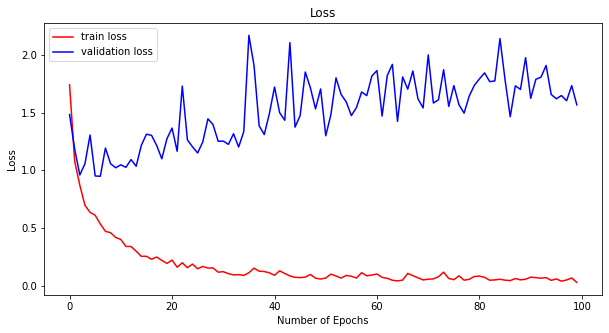

In [46]:
plt.figure(figsize = (10,5))
plt.plot(history1e5.history['loss'],color='r',label="train loss")
plt.plot(history1e5.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
best_score = min(history1e5.history['val_loss'])
best_epoch = history1e5.history['val_loss'].index(best_score)
best_val_acc = history1e5.history['val_accuracy'][best_epoch]
best_acc = history1e5.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  6
best epoch validation accuracy:  0.6973365545272827
best epoch train accuracy:  0.8402965068817139


In [48]:
#evaluate the network 
score = model1e5.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.5619 - accuracy: 0.5939
Test score:  2.561892032623291
Test accuracy:  0.5939394235610962


## (1e6): (1e2) + activation : elu  




In [49]:
#creating object for exercise 1d
model1e6 = Sequential()

# 1st hidden layer
model1e6.add(Dense(256,input_shape=(4096,)))
model1e6.add(BatchNormalization())
model1e6.add(Activation('elu'))
model1e6.add(Dropout(0.2))

# 2nd hidden layer
model1e6.add(Dense(128))
model1e6.add(BatchNormalization())
model1e6.add(Activation('elu'))
model1e6.add(Dropout(0.2))

# 3rd hidden layer
model1e6.add(Dense(64))
model1e6.add(BatchNormalization())
model1e6.add(Activation('elu'))
model1e6.add(Dropout(0.2))

# 4rd hidden layer
model1e6.add(Dense(32))
model1e6.add(BatchNormalization())
model1e6.add(Activation('elu'))
model1e6.add(Dropout(0.2))

#output neuron 
model1e6.add(Dense(10))
#softmax needed in order to get as propability
model1e6.add(Activation('softmax'))
 
model1e6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_23 (Batc (None, 128)               512       
_________________________________________________________________
activation_33 (Activation)   (None, 128)              

In [50]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e6=model1e6.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 9ms/step - loss: 2.1261 - accuracy: 0.2515 - val_loss: 1.8113 - val_accuracy: 0.3584

Epoch 00001: val_loss improved from inf to 1.81133, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 1.2185 - accuracy: 0.6053 - val_loss: 1.1781 - val_accuracy: 0.6150

Epoch 00002: val_loss improved from 1.81133 to 1.17812, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.9097 - accuracy: 0.7329 - val_loss: 0.9571 - val_accuracy: 0.7070

Epoch 00003: val_loss improved from 1.17812 to 0.95713, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 0.7674 - accuracy: 0.7730 - val_loss: 1.0734 - val_accuracy: 0.6610

Epoch 00004: val_loss did not improve from 0.95713
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.6754 - accuracy: 0.7923 - val_loss: 0.96

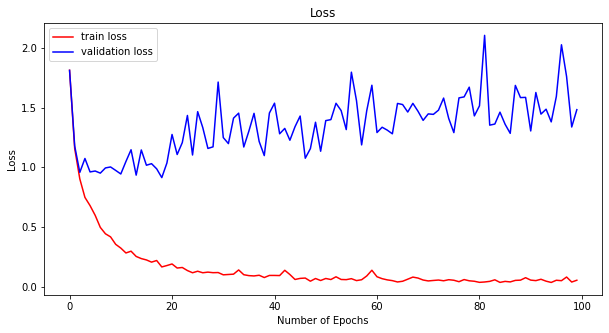

In [51]:
plt.figure(figsize = (10,5))
plt.plot(history1e6.history['loss'],color='r',label="train loss")
plt.plot(history1e6.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
best_score = min(history1e6.history['val_loss'])
best_epoch = history1e6.history['val_loss'].index(best_score)
best_val_acc = history1e6.history['val_accuracy'][best_epoch]
best_acc = history1e6.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  18
best epoch validation accuracy:  0.7336561679840088
best epoch train accuracy:  0.9555255770683289


In [53]:
#evaluate the network 
score = model1e6.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 3.3232 - accuracy: 0.6000
Test score:  3.3232004642486572
Test accuracy:  0.6000000238418579


## (1e7): (1e2) + activation : sigmoid  




In [54]:
#creating object for exercise 1d
model1e7 = Sequential()

# 1st hidden layer
model1e7.add(Dense(256,input_shape=(4096,)))
model1e7.add(BatchNormalization())
model1e7.add(Activation('sigmoid'))
model1e7.add(Dropout(0.2))

# 2nd hidden layer
model1e7.add(Dense(128))
model1e7.add(BatchNormalization())
model1e7.add(Activation('sigmoid'))
model1e7.add(Dropout(0.2))

# 3rd hidden layer
model1e7.add(Dense(64))
model1e7.add(BatchNormalization())
model1e7.add(Activation('sigmoid'))
model1e7.add(Dropout(0.2))

# 4rd hidden layer
model1e7.add(Dense(32))
model1e7.add(BatchNormalization())
model1e7.add(Activation('sigmoid'))
model1e7.add(Dropout(0.2))

#output neuron 
model1e7.add(Dense(10))
#softmax needed in order to get as propability
model1e7.add(Activation('softmax'))
 
model1e7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
activation_37 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
activation_38 (Activation)   (None, 128)              

In [55]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e7=model1e7.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.3476 - accuracy: 0.1649 - val_loss: 2.2400 - val_accuracy: 0.1525

Epoch 00001: val_loss improved from inf to 2.23995, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.9377 - accuracy: 0.3697 - val_loss: 1.9984 - val_accuracy: 0.4310

Epoch 00002: val_loss improved from 2.23995 to 1.99842, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 1.7633 - accuracy: 0.4834 - val_loss: 1.7805 - val_accuracy: 0.6174

Epoch 00003: val_loss improved from 1.99842 to 1.78051, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 1.6802 - accuracy: 0.4936 - val_loss: 1.6152 - val_accuracy: 0.5932

Epoch 00004: val_loss improved from 1.78051 to 1.61524, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 1.6

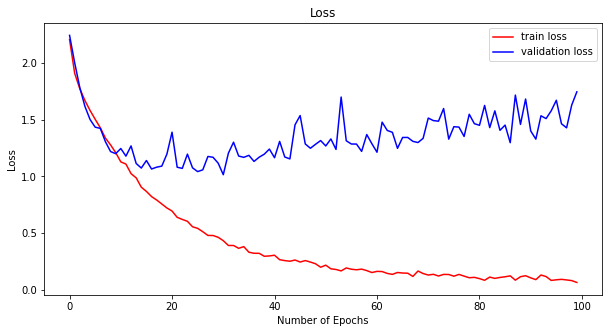

In [56]:
plt.figure(figsize = (10,5))
plt.plot(history1e7.history['loss'],color='r',label="train loss")
plt.plot(history1e7.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [57]:
best_score = min(history1e7.history['val_loss'])
best_epoch = history1e7.history['val_loss'].index(best_score)
best_val_acc = history1e7.history['val_accuracy'][best_epoch]
best_acc = history1e7.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  30
best epoch validation accuracy:  0.6876513361930847
best epoch train accuracy:  0.8982479572296143


In [58]:
#evaluate the network 
score = model1e7.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 4ms/step - loss: 2.0955 - accuracy: 0.5455
Test score:  2.095510721206665
Test accuracy:  0.5454545617103577


## (1e8): (1e2) + activation : tanh  




In [59]:
#creating object for exercise 1d
model1e8 = Sequential()

# 1st hidden layer
model1e8.add(Dense(256,input_shape=(4096,)))
model1e8.add(BatchNormalization())
model1e8.add(Activation('tanh'))
model1e8.add(Dropout(0.2))

# 2nd hidden layer
model1e8.add(Dense(128))
model1e8.add(BatchNormalization())
model1e8.add(Activation('tanh'))
model1e8.add(Dropout(0.2))

# 3rd hidden layer
model1e8.add(Dense(64))
model1e8.add(BatchNormalization())
model1e8.add(Activation('tanh'))
model1e8.add(Dropout(0.2))

# 4rd hidden layer
model1e8.add(Dense(32))
model1e8.add(BatchNormalization())
model1e8.add(Activation('tanh'))
model1e8.add(Dropout(0.2))

#output neuron 
model1e8.add(Dense(10))
#softmax needed in order to get as propability
model1e8.add(Activation('softmax'))
 
model1e8.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
activation_42 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_31 (Batc (None, 128)               512       
_________________________________________________________________
activation_43 (Activation)   (None, 128)             

In [60]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1e8=model1e8.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.0728 - accuracy: 0.2678 - val_loss: 1.6688 - val_accuracy: 0.4068

Epoch 00001: val_loss improved from inf to 1.66883, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 1.3016 - accuracy: 0.5935 - val_loss: 1.2736 - val_accuracy: 0.5787

Epoch 00002: val_loss improved from 1.66883 to 1.27363, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 0.9420 - accuracy: 0.7381 - val_loss: 1.3022 - val_accuracy: 0.5835

Epoch 00003: val_loss did not improve from 1.27363
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.8049 - accuracy: 0.7769 - val_loss: 1.1471 - val_accuracy: 0.6199

Epoch 00004: val_loss improved from 1.27363 to 1.14713, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6684 - accuracy: 0.8188 - val_loss: 1.21

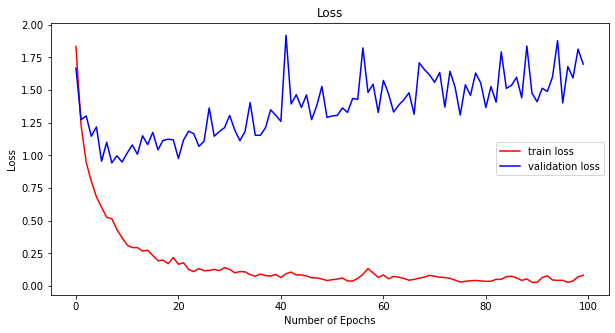

In [61]:
plt.figure(figsize = (10,5))
plt.plot(history1e8.history['loss'],color='r',label="train loss")
plt.plot(history1e8.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [62]:
best_score = min(history1e8.history['val_loss'])
best_epoch = history1e8.history['val_loss'].index(best_score)
best_val_acc = history1e8.history['val_accuracy'][best_epoch]
best_acc = history1e8.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  7
best epoch validation accuracy:  0.694915235042572
best epoch train accuracy:  0.8571428656578064


In [63]:
#evaluate the network 
score = model1e8.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.4220 - accuracy: 0.5758
Test score:  2.421962022781372
Test accuracy:  0.5757575631141663


## (1e9): (1e2) + optimization : SGD 

In [69]:
#creating object for exercise 1e9
model1e9 = Sequential()

# 1st hidden layer
model1e9.add(Dense(256,input_shape=(4096,)))
model1e9.add(BatchNormalization())
model1e9.add(Activation('relu'))
model1e9.add(Dropout(0.2))

# 2nd hidden layer
model1e9.add(Dense(128))
model1e9.add(BatchNormalization())
model1e9.add(Activation('relu'))
model1e9.add(Dropout(0.2))

# 3rd hidden layer
model1e9.add(Dense(64))
model1e9.add(BatchNormalization())
model1e9.add(Activation('relu'))
model1e9.add(Dropout(0.2))

# 4rd hidden layer
model1e9.add(Dense(32))
model1e9.add(BatchNormalization())
model1e9.add(Activation('relu'))
model1e9.add(Dropout(0.2))

#output neuron 
model1e9.add(Dense(10))
#softmax needed in order to get as propability
model1e9.add(Activation('softmax'))
 
model1e9.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)               1024      
_________________________________________________________________
activation_52 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_39 (Batc (None, 128)               512       
_________________________________________________________________
activation_53 (Activation)   (None, 128)             

In [70]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1e9.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
history1e9=model1e9.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 9ms/step - loss: 2.5924 - accuracy: 0.1269 - val_loss: 2.2191 - val_accuracy: 0.2203

Epoch 00001: val_loss improved from inf to 2.21915, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 2.1716 - accuracy: 0.2186 - val_loss: 2.0273 - val_accuracy: 0.3559

Epoch 00002: val_loss improved from 2.21915 to 2.02726, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 1.9118 - accuracy: 0.3489 - val_loss: 1.8360 - val_accuracy: 0.4479

Epoch 00003: val_loss improved from 2.02726 to 1.83600, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 1.7212 - accuracy: 0.4073 - val_loss: 1.6604 - val_accuracy: 0.5278

Epoch 00004: val_loss improved from 1.83600 to 1.66039, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 1.6

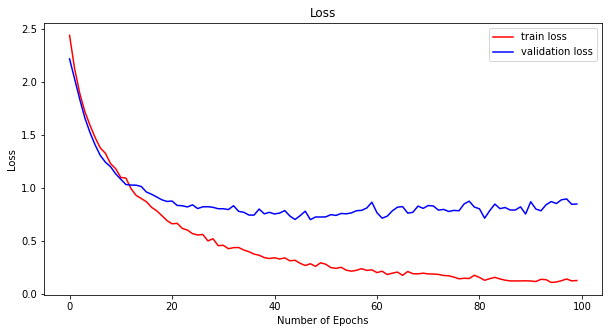

In [71]:
plt.figure(figsize = (10,5))
plt.plot(history1e9.history['loss'],color='r',label="train loss")
plt.plot(history1e9.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [72]:
best_score = min(history1e9.history['val_loss'])
best_epoch = history1e9.history['val_loss'].index(best_score)
best_val_acc = history1e9.history['val_accuracy'][best_epoch]
best_acc = history1e9.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  47
best epoch validation accuracy:  0.7723971009254456
best epoch train accuracy:  0.9231805801391602


In [73]:
#evaluate the network 
score = model1e9.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 2ms/step - loss: 1.4378 - accuracy: 0.7152
Test score:  1.4377713203430176
Test accuracy:  0.7151514887809753


## (1eA): (1e2) + optimization : RMSprop 

In [74]:
#creating object for exercise 1d
model1eA = Sequential()

# 1st hidden layer
model1eA.add(Dense(256,input_shape=(4096,)))
model1eA.add(BatchNormalization())
model1eA.add(Activation('relu'))
model1eA.add(Dropout(0.2))

# 2nd hidden layer
model1eA.add(Dense(128))
model1eA.add(BatchNormalization())
model1eA.add(Activation('relu'))
model1eA.add(Dropout(0.2))

# 3rd hidden layer
model1eA.add(Dense(64))
model1eA.add(BatchNormalization())
model1eA.add(Activation('relu'))
model1eA.add(Dropout(0.2))

# 4rd hidden layer
model1eA.add(Dense(32))
model1eA.add(BatchNormalization())
model1eA.add(Activation('relu'))
model1eA.add(Dropout(0.2))

#output neuron 
model1eA.add(Dense(10))
#softmax needed in order to get as propability
model1eA.add(Activation('softmax'))
 
model1eA.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_42 (Batc (None, 256)               1024      
_________________________________________________________________
activation_57 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_43 (Batc (None, 128)               512       
_________________________________________________________________
activation_58 (Activation)   (None, 128)             

In [75]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eA.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history1eA=model1eA.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 10ms/step - loss: 2.4346 - accuracy: 0.1681 - val_loss: 2.1436 - val_accuracy: 0.2276

Epoch 00001: val_loss improved from inf to 2.14356, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.7687 - accuracy: 0.3929 - val_loss: 1.8934 - val_accuracy: 0.3487

Epoch 00002: val_loss improved from 2.14356 to 1.89342, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4137 - accuracy: 0.5600 - val_loss: 1.7558 - val_accuracy: 0.4552

Epoch 00003: val_loss improved from 1.89342 to 1.75578, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 1.1139 - accuracy: 0.6929 - val_loss: 1.1512 - val_accuracy: 0.6174

Epoch 00004: val_loss improved from 1.75578 to 1.15117, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.

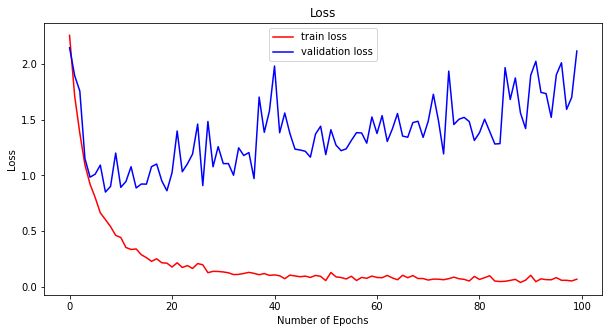

In [76]:
plt.figure(figsize = (10,5))
plt.plot(history1eA.history['loss'],color='r',label="train loss")
plt.plot(history1eA.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [77]:
best_score = min(history1eA.history['val_loss'])
best_epoch = history1eA.history['val_loss'].index(best_score)
best_val_acc = history1eA.history['val_accuracy'][best_epoch]
best_acc = history1eA.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  7
best epoch validation accuracy:  0.7360774874687195
best epoch train accuracy:  0.8301886916160583


In [78]:
#evaluate the network 
score = model1eA.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 3.2759 - accuracy: 0.6485
Test score:  3.275902271270752
Test accuracy:  0.6484848260879517


## (1eB): (1e2) + optimization : adadelta 

In [79]:
#creating object for exercise 1d
model1eB = Sequential()

# 1st hidden layer
model1eB.add(Dense(256,input_shape=(4096,)))
model1eB.add(BatchNormalization())
model1eB.add(Activation('relu'))
model1eB.add(Dropout(0.2))

# 2nd hidden layer
model1eB.add(Dense(128))
model1eB.add(BatchNormalization())
model1eB.add(Activation('relu'))
model1eB.add(Dropout(0.2))

# 3rd hidden layer
model1eB.add(Dense(64))
model1eB.add(BatchNormalization())
model1eB.add(Activation('relu'))
model1eB.add(Dropout(0.2))

# 4rd hidden layer
model1eB.add(Dense(32))
model1eB.add(BatchNormalization())
model1eB.add(Activation('relu'))
model1eB.add(Dropout(0.2))

#output neuron 
model1eB.add(Dense(10))
#softmax needed in order to get as propability
model1eB.add(Activation('softmax'))
 
model1eB.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
activation_62 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
activation_63 (Activation)   (None, 128)             

In [80]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eB.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
history1eB=model1eB.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 1s 10ms/step - loss: 2.7021 - accuracy: 0.1140 - val_loss: 2.2774 - val_accuracy: 0.1453

Epoch 00001: val_loss improved from inf to 2.27735, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 2.7280 - accuracy: 0.1161 - val_loss: 2.2830 - val_accuracy: 0.1211

Epoch 00002: val_loss did not improve from 2.27735
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 2.7212 - accuracy: 0.1024 - val_loss: 2.2863 - val_accuracy: 0.1404

Epoch 00003: val_loss did not improve from 2.27735
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 2.6944 - accuracy: 0.0943 - val_loss: 2.2932 - val_accuracy: 0.1308

Epoch 00004: val_loss did not improve from 2.27735
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 2.6662 - accuracy: 0.1041 - val_loss: 2.3017 - val_accuracy: 0.1501

Epoch 00005: val_loss did not improve from 2.27735

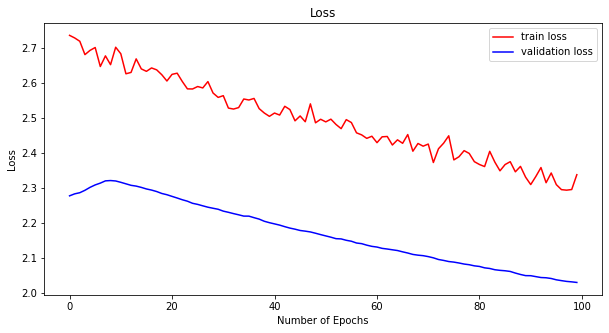

In [81]:
plt.figure(figsize = (10,5))
plt.plot(history1eB.history['loss'],color='r',label="train loss")
plt.plot(history1eB.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [82]:
best_score = min(history1eB.history['val_loss'])
best_epoch = history1eB.history['val_loss'].index(best_score)
best_val_acc = history1eB.history['val_accuracy'][best_epoch]
best_acc = history1eB.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  99
best epoch validation accuracy:  0.3026634454727173
best epoch train accuracy:  0.1960916370153427


In [83]:
#evaluate the network 
score = model1eB.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.2045 - accuracy: 0.1636
Test score:  2.2044763565063477
Test accuracy:  0.16363635659217834


## (1eC): (1e2) + optimization : Nadam  

In [84]:
#creating object for exercise 1d
model1eC = Sequential()

# 1st hidden layer
model1eC.add(Dense(256,input_shape=(4096,)))
model1eC.add(BatchNormalization())
model1eC.add(Activation('relu'))
model1eC.add(Dropout(0.2))

# 2nd hidden layer
model1eC.add(Dense(128))
model1eC.add(BatchNormalization())
model1eC.add(Activation('relu'))
model1eC.add(Dropout(0.2))

# 3rd hidden layer
model1eC.add(Dense(64))
model1eC.add(BatchNormalization())
model1eC.add(Activation('relu'))
model1eC.add(Dropout(0.2))

# 4rd hidden layer
model1eC.add(Dense(32))
model1eC.add(BatchNormalization())
model1eC.add(Activation('relu'))
model1eC.add(Dropout(0.2))

#output neuron 
model1eC.add(Dense(10))
#softmax needed in order to get as propability
model1eC.add(Activation('softmax'))
 
model1eC.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
activation_68 (Activation)   (None, 128)             

In [85]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eC.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
history1eC=model1eC.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 11ms/step - loss: 2.4078 - accuracy: 0.1494 - val_loss: 2.1239 - val_accuracy: 0.1913

Epoch 00001: val_loss improved from inf to 2.12391, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 1.7821 - accuracy: 0.3797 - val_loss: 1.7218 - val_accuracy: 0.3947

Epoch 00002: val_loss improved from 2.12391 to 1.72175, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: 1.3915 - accuracy: 0.5401 - val_loss: 1.2264 - val_accuracy: 0.5738

Epoch 00003: val_loss improved from 1.72175 to 1.22637, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 1.1409 - accuracy: 0.6472 - val_loss: 1.1308 - val_accuracy: 0.6223

Epoch 00004: val_loss improved from 1.22637 to 1.13081, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 1.

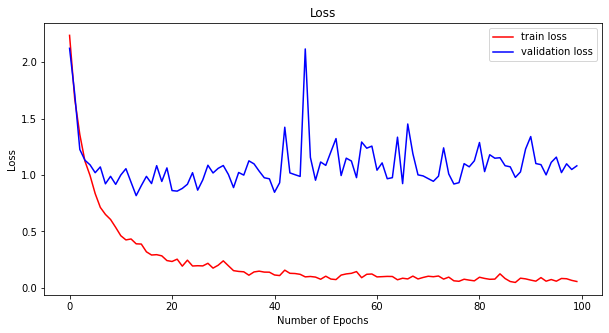

In [86]:
plt.figure(figsize = (10,5))
plt.plot(history1eC.history['loss'],color='r',label="train loss")
plt.plot(history1eC.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [87]:
best_score = min(history1eC.history['val_loss'])
best_epoch = history1eC.history['val_loss'].index(best_score)
best_val_acc = history1eC.history['val_accuracy'][best_epoch]
best_acc = history1eC.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  13
best epoch validation accuracy:  0.7481840252876282
best epoch train accuracy:  0.8894878625869751


In [88]:
#evaluate the network 
score = model1eC.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.1420 - accuracy: 0.6727
Test score:  2.1419904232025146
Test accuracy:  0.6727272868156433


## (1eD): (1e2) + data preproccessing 

In [89]:
x_train, x_val, Y_train,Y_val = train_test_split(x,y, test_size=0.2, random_state = 42)
x_train, x_test, Y_train,Y_test = train_test_split(x_train,Y_train, test_size=0.1, random_state = 42)

print("x_train shape:",x_train.shape)
print("x_val shape:",x_val.shape)
print("x_test shape:",x_test.shape)

datagen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
new_images = datagen.flow(x_train, batch_size = 1)

x_train= x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1]*x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)


x_train shape: (1484, 64, 64, 1)
x_val shape: (413, 64, 64, 1)
x_test shape: (165, 64, 64, 1)


In [90]:
#creating object for exercise 1d
model1eD = Sequential()

# 1st hidden layer
model1eD.add(Dense(256,input_shape=(4096,)))
model1eD.add(BatchNormalization())
model1eD.add(Activation('relu'))
model1eD.add(Dropout(0.2))

# 2nd hidden layer
model1eD.add(Dense(128))
model1eD.add(BatchNormalization())
model1eD.add(Activation('relu'))
model1eD.add(Dropout(0.2))

# 3rd hidden layer
model1eD.add(Dense(64))
model1eD.add(BatchNormalization())
model1eD.add(Activation('relu'))
model1eD.add(Dropout(0.2))

# 4rd hidden layer
model1eD.add(Dense(32))
model1eD.add(BatchNormalization())
model1eD.add(Activation('relu'))
model1eD.add(Dropout(0.2))

#output neuron 
model1eD.add(Dense(10))
#softmax needed in order to get as propability
model1eD.add(Activation('softmax'))
 
model1eD.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_54 (Batc (None, 256)               1024      
_________________________________________________________________
activation_72 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
activation_73 (Activation)   (None, 128)             

In [91]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eD.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history1eD=model1eD.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 10ms/step - loss: 2.3520 - accuracy: 0.1840 - val_loss: 2.1226 - val_accuracy: 0.3051

Epoch 00001: val_loss improved from inf to 2.12261, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.7525 - accuracy: 0.4171 - val_loss: 2.0561 - val_accuracy: 0.3293

Epoch 00002: val_loss improved from 2.12261 to 2.05615, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.4207 - accuracy: 0.5474 - val_loss: 1.2494 - val_accuracy: 0.5448

Epoch 00003: val_loss improved from 2.05615 to 1.24943, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 1.1116 - accuracy: 0.6827 - val_loss: 1.2424 - val_accuracy: 0.5327

Epoch 00004: val_loss improved from 1.24943 to 1.24242, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 0.

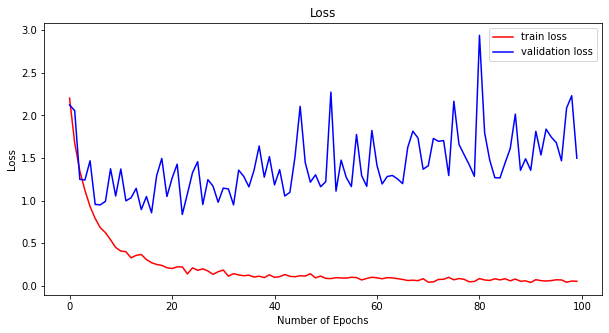

In [92]:
plt.figure(figsize = (10,5))
plt.plot(history1eD.history['loss'],color='r',label="train loss")
plt.plot(history1eD.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [93]:
best_score = min(history1eD.history['val_loss'])
best_epoch = history1eD.history['val_loss'].index(best_score)
best_val_acc = history1eD.history['val_accuracy'][best_epoch]
best_acc = history1eD.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  22
best epoch validation accuracy:  0.7917675375938416
best epoch train accuracy:  0.9299191236495972


In [94]:
#evaluate the network 
score = model1eD.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 2.8063 - accuracy: 0.6848
Test score:  2.8063011169433594
Test accuracy:  0.6848484873771667


##(1eE): (1e2) + dimensionality reduction (PCA 0.5)

In [95]:
x_train, x_val, Y_train,Y_val = train_test_split(x,y, test_size=0.2, random_state = 42)
x_train, x_test, Y_train,Y_test = train_test_split(x_train,Y_train, test_size=0.1, random_state = 42)


x_train= x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1]*x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

In [96]:
pca = PCA(.5)
pca.fit(x_train)
pca.fit(x_val)
pca.fit(x_test)

PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [97]:
#creating object for exercise 1eE
model1eE = Sequential()

# 1st hidden layer
model1eE.add(Dense(256,input_shape=(4096,)))
model1eE.add(BatchNormalization())
model1eE.add(Activation('relu'))
model1eE.add(Dropout(0.2))

# 2nd hidden layer
model1eE.add(Dense(128))
model1eE.add(BatchNormalization())
model1eE.add(Activation('relu'))
model1eE.add(Dropout(0.2))

# 3rd hidden layer
model1eE.add(Dense(64))
model1eE.add(BatchNormalization())
model1eE.add(Activation('relu'))
model1eE.add(Dropout(0.2))

# 4rd hidden layer
model1eE.add(Dense(32))
model1eE.add(BatchNormalization())
model1eE.add(Activation('relu'))
model1eE.add(Dropout(0.2))

#output neuron 
model1eE.add(Dense(10))
#softmax needed in order to get as propability
model1eE.add(Activation('softmax'))
 
model1eE.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_59 (Batc (None, 128)               512       
_________________________________________________________________
activation_78 (Activation)   (None, 128)             

In [98]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eE.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history1eE=model1eE.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
58/58 [==============================] - 2s 10ms/step - loss: 2.2912 - accuracy: 0.2079 - val_loss: 2.0636 - val_accuracy: 0.3293

Epoch 00001: val_loss improved from inf to 2.06362, saving model to weights.best.hdf5
Epoch 2/100
58/58 [==============================] - 0s 7ms/step - loss: 1.5530 - accuracy: 0.4988 - val_loss: 1.6169 - val_accuracy: 0.4431

Epoch 00002: val_loss improved from 2.06362 to 1.61688, saving model to weights.best.hdf5
Epoch 3/100
58/58 [==============================] - 0s 6ms/step - loss: 1.2318 - accuracy: 0.6229 - val_loss: 1.2007 - val_accuracy: 0.5860

Epoch 00003: val_loss improved from 1.61688 to 1.20075, saving model to weights.best.hdf5
Epoch 4/100
58/58 [==============================] - 0s 6ms/step - loss: 1.0057 - accuracy: 0.7055 - val_loss: 0.8741 - val_accuracy: 0.7070

Epoch 00004: val_loss improved from 1.20075 to 0.87411, saving model to weights.best.hdf5
Epoch 5/100
58/58 [==============================] - 0s 6ms/step - loss: 0.

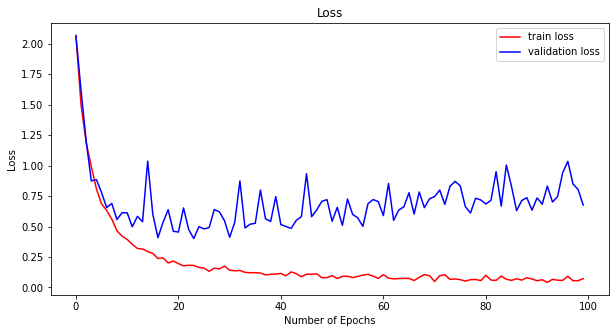

In [99]:
plt.figure(figsize = (10,5))
plt.plot(history1eE.history['loss'],color='r',label="train loss")
plt.plot(history1eE.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [100]:
best_score = min(history1eE.history['val_loss'])
best_epoch = history1eE.history['val_loss'].index(best_score)
best_val_acc = history1eE.history['val_accuracy'][best_epoch]
best_acc = history1eE.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  23
best epoch validation accuracy:  0.8958837985992432
best epoch train accuracy:  0.9412398934364319


In [101]:
#evaluate the network 
score = model1eE.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 1.7822 - accuracy: 0.7536
Test score:  1.7821632623672485
Test accuracy:  0.7536231875419617


##(1eF): (1e2) + dimensionality reduction (PCA 0.7)

In [103]:
x_train, x_val, Y_train,Y_val = train_test_split(x,y, test_size=0.2, random_state = 42)
x_train, x_test, Y_train,Y_test = train_test_split(x_train,Y_train, test_size=0.1, random_state = 42)


x_train= x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1]*x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

In [104]:
pca = PCA(.7)
pca.fit(x_train)
pca.fit(x_val)
pca.fit(x_test)

PCA(copy=True, iterated_power='auto', n_components=0.7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [105]:
#creating object for exercise 1d
model1eF = Sequential()

# 1st hidden layer
model1eF.add(Dense(256,input_shape=(4096,)))
model1eF.add(BatchNormalization())
model1eF.add(Activation('relu'))
model1eF.add(Dropout(0.2))

# 2nd hidden layer
model1eF.add(Dense(128))
model1eF.add(BatchNormalization())
model1eF.add(Activation('relu'))
model1eF.add(Dropout(0.2))

# 3rd hidden layer
model1eF.add(Dense(64))
model1eF.add(BatchNormalization())
model1eF.add(Activation('relu'))
model1eF.add(Dropout(0.2))

# 4rd hidden layer
model1eF.add(Dense(32))
model1eF.add(BatchNormalization())
model1eF.add(Activation('relu'))
model1eF.add(Dropout(0.2))

#output neuron 
model1eF.add(Dense(10))
#softmax needed in order to get as propability
model1eF.add(Activation('softmax'))
 
model1eF.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 256)               1048832   
_________________________________________________________________
batch_normalization_62 (Batc (None, 256)               1024      
_________________________________________________________________
activation_82 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_63 (Batc (None, 128)               512       
_________________________________________________________________
activation_83 (Activation)   (None, 128)             

In [106]:
#for the best epoch
filepath="weights.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint]

model1eF.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history1eF=model1eF.fit(x_train, Y_train, epochs=100,validation_data=(x_val,Y_val), callbacks=callbacks_list, verbose=1)

Epoch 1/100
47/47 [==============================] - 2s 10ms/step - loss: 2.3897 - accuracy: 0.1856 - val_loss: 2.1495 - val_accuracy: 0.2542

Epoch 00001: val_loss improved from inf to 2.14951, saving model to weights.best.hdf5
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.6975 - accuracy: 0.4292 - val_loss: 1.5253 - val_accuracy: 0.4697

Epoch 00002: val_loss improved from 2.14951 to 1.52530, saving model to weights.best.hdf5
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 1.3590 - accuracy: 0.5826 - val_loss: 1.5107 - val_accuracy: 0.5061

Epoch 00003: val_loss improved from 1.52530 to 1.51066, saving model to weights.best.hdf5
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 1.1289 - accuracy: 0.6720 - val_loss: 1.1412 - val_accuracy: 0.6320

Epoch 00004: val_loss improved from 1.51066 to 1.14119, saving model to weights.best.hdf5
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.

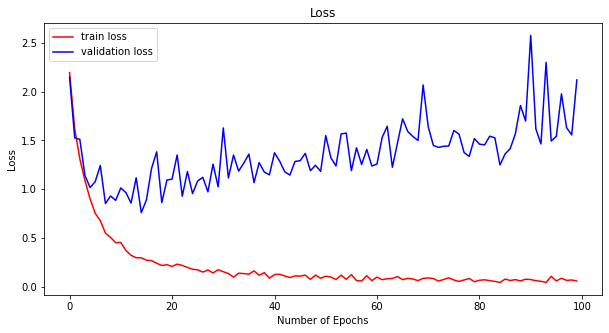

In [107]:
plt.figure(figsize = (10,5))
plt.plot(history1eF.history['loss'],color='r',label="train loss")
plt.plot(history1eF.history['val_loss'], color='b', label="validation loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [108]:
best_score = min(history1eF.history['val_loss'])
best_epoch = history1eF.history['val_loss'].index(best_score)
best_val_acc = history1eF.history['val_accuracy'][best_epoch]
best_acc = history1eF.history['accuracy'][best_epoch]

print('best epoch: ',best_epoch)
print('best epoch validation accuracy: ',best_val_acc)
print('best epoch train accuracy: ',best_acc)

best epoch:  14
best epoch validation accuracy:  0.7457627058029175
best epoch train accuracy:  0.9056603908538818


In [109]:
#evaluate the network 
score = model1eF.evaluate(x_test,Y_test)
print('Test score: ', score[0])   
print('Test accuracy: ', score[1])

6/6 [==============================] - 0s 3ms/step - loss: 3.6421 - accuracy: 0.5697
Test score:  3.642106771469116
Test accuracy:  0.5696969628334045
